Found 3757 files belonging to 5 classes.
Using 3006 files for training.
Found 3757 files belonging to 5 classes.
Using 751 files for validation.
Tamaño del conjunto de entrenamiento: 47
Tamaño del conjunto de validación: 6
Tamaño del conjunto de prueba: 6
Conteo de imágenes por clase: defaultdict(<class 'int'>, {'Chinche salivosa': 825, 'Clororis': 404, 'Hoja sana': 846, 'Roya naranja': 1160, 'Roya purpura': 522})
Pesos de clase: {0: 0.9107878787878788, 1: 1.85990099009901, 2: 0.8881796690307329, 3: 0.6477586206896552, 4: 1.439463601532567}
Image Shape: (64, 128, 128, 3)
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 582ms/step - accuracy: 0.5618 - loss: 3.6862 - val_accuracy: 0.4974 - val_loss: 3.7342
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 518ms/step - accuracy: 0.8398 - loss: 2.4167 - val_accuracy: 0.4896 - val_loss: 3.2666
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.9088 - loss: 1.7440 - val_accuracy: 0.5182 - val_loss: 3.2761
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━

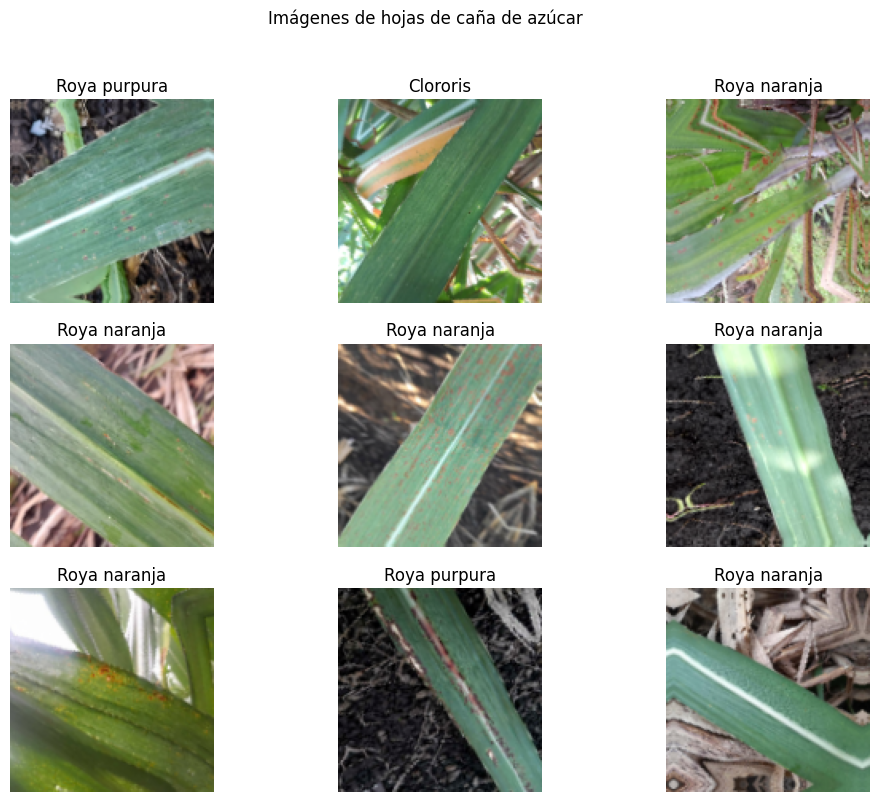

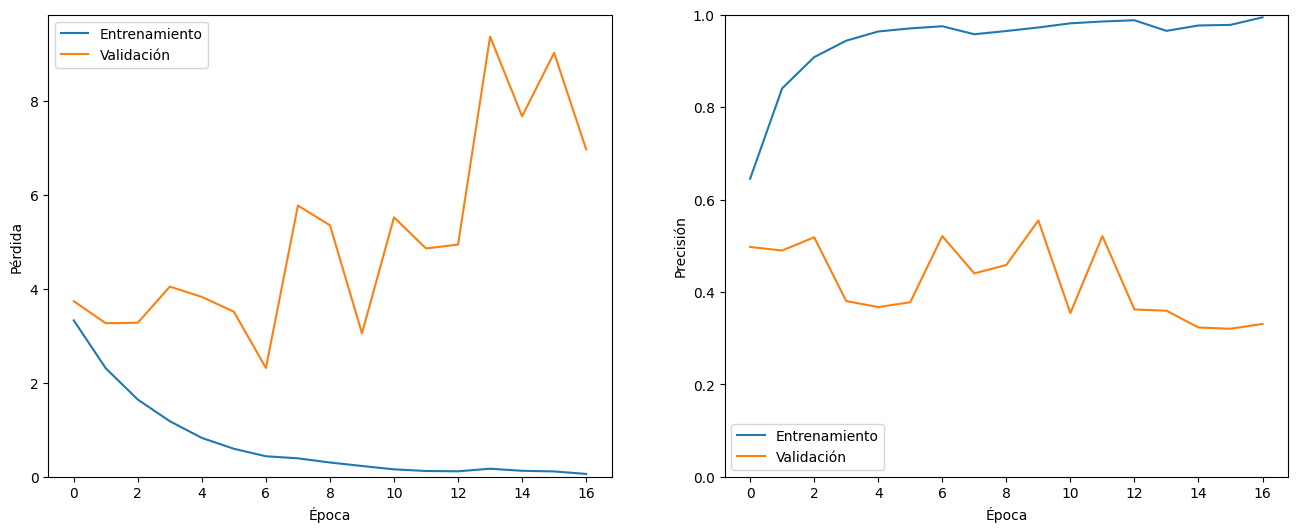

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.5370 - loss: 2.2449
Resultados de evaluación en el conjunto de prueba:
accuracy: 0.4986
loss: 2.4478
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step
Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.78      0.81      0.79        72
        Clororis       0.24      0.88      0.38        32
       Hoja sana       0.84      0.70      0.77        88
    Roya naranja       1.00      0.02      0.03       122
    Roya purpura       0.33      0.62      0.43        53

        accuracy                           0.50       367
       macro avg       0.64      0.60      0.48       367
    weighted avg       0.76      0.50      0.45       367



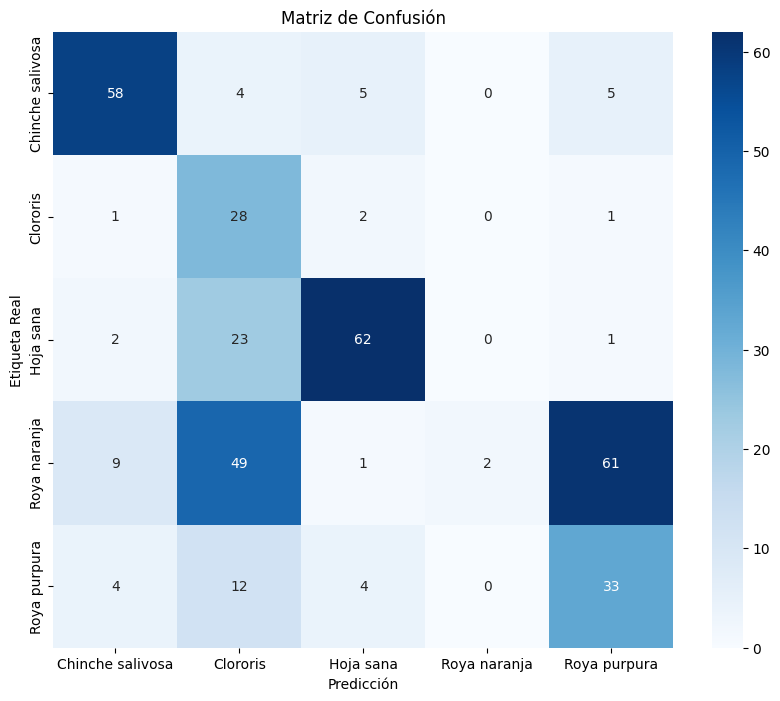

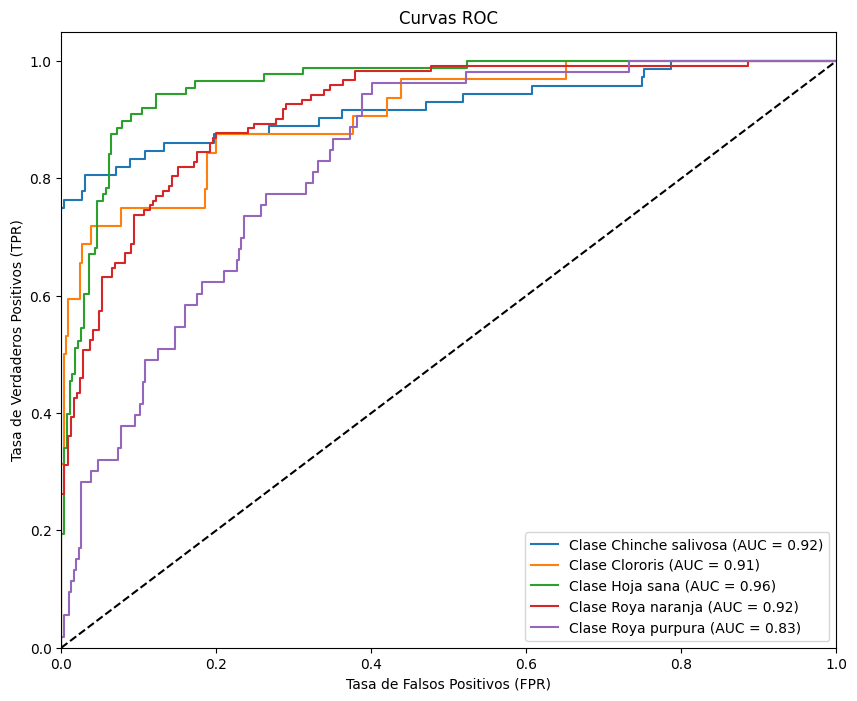

In [2]:
# -*- coding: utf-8 -*-
"""Modelo con técnicas para prevenir overfitting y división de datos corregida"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

"""### **Definir Constantes**"""

EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 64
BUFFER_SIZE = 350
FINE_TUNE_POINT = 100
LEARNING_RATE = 0.001

# from google.colab import drive
# drive.mount('/content/drive')

# DATASET_DIR = '/content/drive/My Drive/arcgis-survey-images'


DATASET_DIR = "../data/arcgis-survey-images-new"

"""### **Cargar los Conjuntos de Datos de Imágenes**"""

# Aumentar validation_split al 30% para reservar más datos para validación y prueba
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,  # Cambiado de 0.2 a 0.3
    subset="training"
)

validation_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,  # Asegurar que coincide con el anterior
    subset="validation"
)

class_names = train_ds.class_names

# Ahora dividimos validation_test_ds en validation_ds y test_ds
validation_test_ds_size = validation_test_ds.cardinality().numpy()

# Calculamos el 50% del conjunto validation_test_ds para validación y el 50% para prueba
val_size = int(0.5 * validation_test_ds_size)
test_size = validation_test_ds_size - val_size

validation_ds = validation_test_ds.take(val_size)
test_ds = validation_test_ds.skip(val_size)

print(f"Tamaño del conjunto de entrenamiento: {train_ds.cardinality().numpy()}")
print(f"Tamaño del conjunto de validación: {validation_ds.cardinality().numpy()}")
print(f"Tamaño del conjunto de prueba: {test_ds.cardinality().numpy()}")

# Verificar que los conjuntos no estén vacíos
if validation_ds.cardinality().numpy() == 0 or test_ds.cardinality().numpy() == 0:
    raise ValueError("El conjunto de validación o prueba está vacío. Ajusta validation_split o el tamaño de los conjuntos.")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))



# Calcular los recuentos de cada clase
import os
from collections import defaultdict

class_counts = defaultdict(int)
total_images = 0

for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images
    total_images += num_images

print("Conteo de imágenes por clase:", class_counts)

# Calcular los pesos de clase
class_weight = {}
for i, class_name in enumerate(class_names):
    class_weight[i] = total_images / (len(class_names) * class_counts[class_name])

print("Pesos de clase:", class_weight)

for example_image, example_label in train_ds.take(1):
    break

print(f"Image Shape: {example_image.shape}")

"""### **Visualizar un Conjunto de Datos de Entrenamiento**"""

plt.figure(figsize=(12, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.suptitle("Imágenes de hojas de caña de azúcar")
        plt.axis("off")

train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

"""### **Cargar el Modelo Base**"""

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Congelar las capas del modelo base hasta el punto de ajuste fino
for layer in base_model.layers[:FINE_TUNE_POINT]:
    layer.trainable = False

"""### **Crear el Modelo de Clasificación con Técnicas para Prevenir Overfitting**"""

from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compilar el modelo
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

"""### **Configurar Callbacks para Early Stopping y Reducción de LR**"""

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

"""### **Entrenar el Modelo**"""

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Verificar las claves en history.history
print("Claves disponibles en history.history:", history.history.keys())

"""### **Informe de Clasificación**"""

metrics = history.history

# Comprobar si 'val_loss' y 'val_accuracy' están en metrics
if 'val_loss' in metrics and 'val_accuracy' in metrics:
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], label='Entrenamiento')
    plt.plot(history.epoch, metrics['val_loss'], label='Validación')
    plt.legend()
    plt.ylim([0, max(plt.ylim())])
    plt.ylabel('Pérdida')
    plt.xlabel('Época')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, metrics['accuracy'], label='Entrenamiento')
    plt.plot(history.epoch, metrics['val_accuracy'], label='Validación')
    plt.legend()
    plt.ylim([0, 1])
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.show()
else:
    print("Las métricas de validación no están disponibles en history.history.")

"""### **Evaluación en el Conjunto de Prueba**"""

# Evaluar el modelo en el conjunto de prueba
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en el conjunto de prueba:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Predicción de etiquetas en el conjunto de prueba
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Curvas ROC y AUC para cada clase
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()
